# Object Detection with Yolo



**Welcome to your lab 3 programming assignment. You will learn about object detection using the very powerful YOLO model.**



You will learn to:



- Use object detection on a PASCAL VOC dataset

- Create a yolo model, train, and test it.



**There is a zip file named utils in the files for this lab in canvas. You need to locate it in the same directory with your jupyter note book file. It consists of some helper functions to plot the figure and compute some metrics**

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

        
    

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# Unzip the contents of the utils file

!unzip /content/utils.zip

# Import Important Packages

In [ ]:
import sys
sys.path.append('/kaggle/input/risolab3')  # Add the directory containing your utils file


In [ ]:
import os

import time

import numpy as np

import torch

import torchvision

from torch import nn

from torch.utils import data

from torch.nn import functional as F

from matplotlib import pyplot as plt

from utils.utils import Accumulator,Timer # use Accumulator and Timer to compute the performance

from utils.visualize import * # use visualizatoin to show the plots

from utils.data import load_data_voc # use for loading dataloader

from utils.init import weight_init # use for initilize the parameters of the model

from torch import nn

import torchvision

# Create Dataset and Dataloader



The Pascal Visual Object Classes (VOC) 2012 dataset is one of the most widely used benchmarks for object detection tasks in computer vision. It was introduced as part of a series of annual challenges focused on visual object recognition and has since become a standard for evaluating object detection algorithms.



The VOC 2012 dataset consists of 11,530 images across 20 object categories, including animals (e.g., dog, cat, bird), vehicles (e.g., car, bicycle, bus), and indoor objects (e.g., chair, dining table). Each image is annotated with object bounding boxes and corresponding class labels, making it well-suited for training and evaluating object detection models. The dataset provides a diverse set of real-world scenes, including both indoor and outdoor environments, with varying lighting conditions, object sizes, and levels of occlusion, presenting a significant challenge for modern detection algorithms.



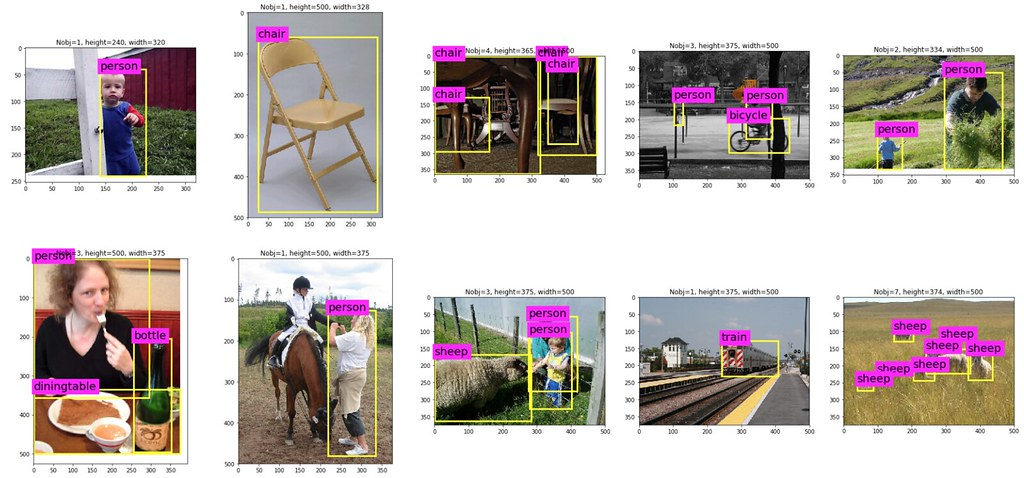



For the first time, you need to set download argument to True to download the data.

In [ ]:
train_iter, test_iter, test_iter_raw = load_data_voc(batch_size=32,download=False)

**Show one example of the dataset**

In [ ]:
iter_loader = iter(train_iter)

images,labels = next(iter_loader)

print(images[0].shape)

print(labels[0].shape)



display(cv2_to_PIL(draw_detection_result(tensor_to_cv2(images[0]), labels[0], raw=False, thres=0.1)))

# Define Yolo Architecture



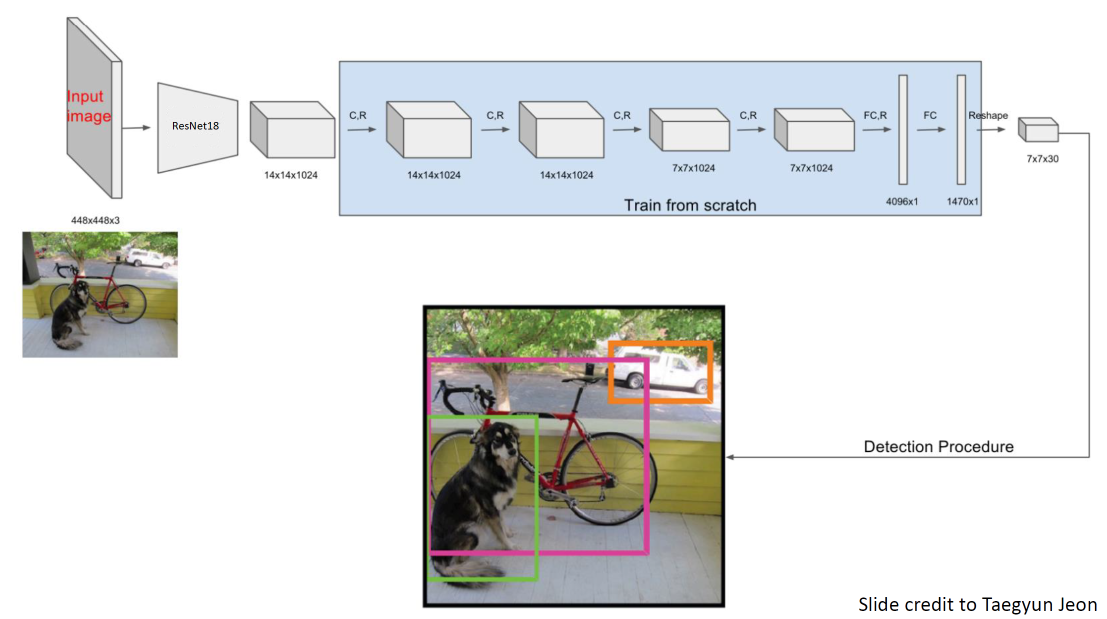



The architecture consists of a backbone (ResNet18) and a head for detecting the object. We need to start with implementing the backbone architecture.

# Backbone (ResNet18)



Torchvision has different pretrain models on ImageNet dataset. Use torchvision.models to load the resnet18. Set pretrained argument to True.

In [ ]:
## Start Code here #

# use torchvision to load model

resnet18 = torchvision.models.resnet18(weights='IMAGENET1K_V1') #pretrained=True)

## End code here ##

#weights='IMAGENET1K_V1'

print(resnet18)




**Expected Output**



ResNet(

  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

  (relu): ReLU(inplace=True)

  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

  (layer1): Sequential(

    (0): BasicBlock(

      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

      (relu): ReLU(inplace=True)

      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

    )

    (1): BasicBlock(

      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

      (relu): ReLU(inplace=True)

      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

    )

  )

  (layer2): Sequential(

    (0): BasicBlock(

      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

...

  )

  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))

  (fc): Linear(in_features=512, out_features=1000, bias=True)

)

**Remove the last two layer from the model (average pooling and FC layers)**



One way to do this is using model.children to seperate the layer.

use model.children() and list() function to seperate layers.



Print two last layers in the list.



Create a new list that contain all layers except two last layers.

In [ ]:
## start code ##

# step1: create a list of the layers with model.children() function

children = list(resnet18.children())





# Step2: print the last two layers of resnet18

print(children[-2:])



# Remove two last layers and create new_childs

new_children = children[:-2]

#print(new_children)

## end code ##

In [ ]:
for i, batch in enumerate(train_iter):

			#timer.start()



			X, y = batch

			#X, y = X.to(devices[0]), y.to(devices[0])

			#yhat = net(X)

			print(X.shape)

			print(y.shape)

			break

**Expected Output**

[AdaptiveAvgPool2d(output_size=(1, 1)), Linear(in_features=512, out_features=1000, bias=True)]

**Use nn.Sequential(*list) to create a pytorch model with the new_children list that generated in the previous cell**

In [ ]:
## start code ##

# use nn.Sequential and * operator to create model without two last layers

backbone =  nn.Sequential(*new_children) # model without avg pool and fc

print(type(backbone))

print(type(resnet18))

children = list(backbone.children())

print(children)





## end code ##

**Take an input from train_data and feed it to the backbone model.**



**Print the shape of the output**



**Print the shape of output for the backbone model**

In [ ]:


images,_ = next(iter_loader)



## start code here ##

# call model on images

output = backbone(images)

# print the shape of output

print(output.shape)

## end code here ##

**Expected Output**



torch.Size([16, 512, 14, 14])

# Yolo Architecture



Define a new model Architecture that contain the backbone and head for the yolo object detectoin.



**Complete the yolo head architecture based on the comments in the code**

In [ ]:
class Yolo(nn.Module):

	def __init__(self, backbone, backbone_out_channels):

		super(Yolo, self).__init__()

		self.backbone = backbone

		self.head = nn.Sequential(



			## START CODE HERE ##

			# [#, ?,14, 14] => [#, 1024 ,14, 14]

			# define a conv2d layer with (input channel = backbone_out_channels, output_channels = 1024 , kernel_size=3, padding = 1)

			nn.Conv2d(in_channels = backbone_out_channels, out_channels = 1024 , kernel_size=3, padding = 1),

			nn.BatchNorm2d(1024), # define a batchnormalization layer with output= 1024

			nn.LeakyReLU(0.1),	  # define a LeakyReLU activation function with slope 0.1





			# [#, 14, 14, 1024] => [#, 7, 7, 1024]

			# define a conv2d layer with (input channel = 1024, output_channels = 1024 , kernel_size=3, padding = 1 , stride = 2)

			nn.Conv2d(in_channels = 1024, out_channels = 1024 , kernel_size=3, padding = 1 , stride = 2),

			nn.BatchNorm2d(1024), 				# define a batchnormalization layer with output= 1024

			nn.LeakyReLU(0.1),					# define a LeakyReLU activation function with slope 0.1





			# [#, 7, 7, 1024] => [#, 7, 7, 1024]

			# define a conv2d layer with (input channel = 1024, output_channels = 1024 , kernel_size=3, padding = 1)

			nn.Conv2d(in_channels = 1024, out_channels = 1024 , kernel_size=3, padding = 1),				

			nn.BatchNorm2d(1024),				# define a batchnormalization layer with output= 1024

			nn.LeakyReLU(0.1),					# define a LeakyReLU activation function with slope 0.1





			# [#, 7, 7, 1024] => [#, 7, 7, 1024]

			# define a conv2d layer with (input channel = 1024, output_channels = 1024 , kernel_size=3, padding = 1)

			nn.Conv2d(in_channels = 1024, out_channels = 1024 , kernel_size=3, padding = 1),

			nn.BatchNorm2d(1024),				# define a batchnormalization layer with output= 1024

			nn.LeakyReLU(0.1),				    #define a LeakyReLU activation function with slope 0.1



			# [#, 7, 7, 1024] => [#, 7*7*1024]

			# define nn.Flatten() layer to reshape the output as a vector

			nn.Flatten(),			 



			# [#, 7*7*1024] => [#, 4096]

			# Define a linear (Fc) layer with input size = 7 * 7 * 1024 and output size 4096

			nn.Linear(50176, 4096),				

			#define a LeakyReLU activation function with slope 0.1

			nn.LeakyReLU(0.1),				 





			# [#, 4096] => [#, 7*7*30]

			# Define a linear (Fc) layer with input size = 7096 and output size 7*7*30

			nn.Linear(4096, 1470),				



			# Normalize to [0, 1] by using sigmoid activatoin function

			nn.Sigmoid(),





			# [#, 7*7*30] => [#, 7, 7, 30]

			nn.Unflatten(1, (7,7,30))				# use nn.Unflatten() to conver the shape to 7 x 7 x 30





			#End code here

		)

		self.net = nn.Sequential(self.backbone)

		self.net2 = nn.Sequential(self.head)



	def forward(self, X):

		net = self.net(X)

		

		

		return self.net2(net)


# Create yolo model



You need to specify the backbone_out_channels argument base on the number of output channels in the backbone

In [ ]:
## START CODE HERE ##

# Create a yolo model based on the back bone and number of output features for resnet18

net = Yolo(backbone, 512)

# End Code Here ##

# yolo loss functoin



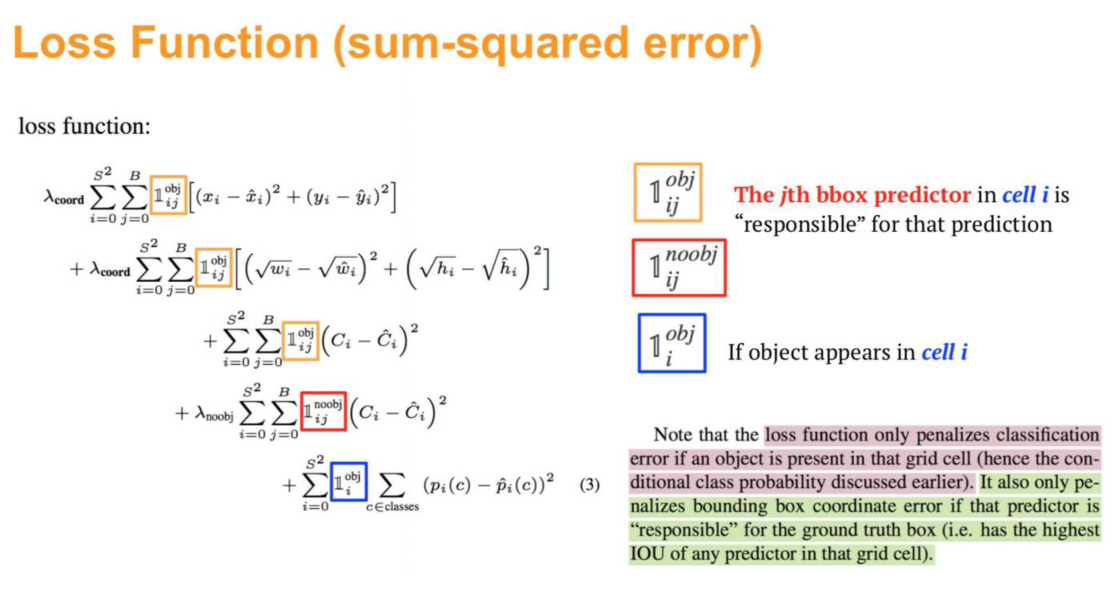


**the following functions are responsible for generating cell idx for x and y dimensions. the calc_coord function convert the coordinate to the relative coordinate based on the x and y indices**



You need to find **y_area** and **yhat_area** from **y** and **yhat**. You learned from the lecture that the 10 first values in **y** and **yhat** show the coordinate and next 20 values show the classes. Also at the end of the code in the cell below you need to use the figure above to generate the loss function.

In [ ]:
def yolo_loss(yhat, y):

	"""

	Args:

		yhat: [#, 7, 7, 30]

		y: [#, 7, 7, 30]

	Returns:

		loss: [#]

	"""

	with torch.no_grad():

		# arrange cell xidx, yidx

		# [7, 7]

		cell_xidx = (torch.arange(49) % 7).reshape(7, 7)

		cell_yidx = (torch.div(torch.arange(49), 7, rounding_mode='floor')).reshape(7, 7)

		# transform to [7, 7, 2]

		cell_xidx.unsqueeze_(-1)

		cell_yidx.unsqueeze_(-1)

		cell_xidx.expand(7, 7, 2)

		cell_yidx.expand(7, 7, 2)

		# move to device

		cell_xidx = cell_xidx.to(yhat.device)

		cell_yidx = cell_yidx.to(yhat.device)



	def calc_coord(val):			## BB Area Calculation 

		with torch.no_grad():

			# transform cell relative coordinates to image relative coordinates

			x = (val[..., 0] + cell_xidx) / 7.0

			y = (val[..., 1] + cell_yidx) / 7.0



			return (x - val[..., 2] / 2.0,

				x + val[..., 2] / 2.0,

				y - val[..., 3] / 2.0,

				y + val[..., 3] / 2.0)

    ## START CODE HERE ##	

	

	# find the coordinate label in y the output shoud have the size (-1, 7, 7, 2, 5), y.shape = (16, 7, 7, 30) -> (16,7,7,2,5)

	y_area = y[:,:,:,:10].view(-1, 7, 7, 2, 5)  # (16,7,7,30) -> (16,7,7,10) -> (reshape) -> (16,7,7,2,5)

	#print('print-yArea_shape', y_area.shape)

	yhat_area = yhat[:,:,:,0:10].view(-1, 7, 7, 2, 5)  # find the coordinate label in yhat the output shoud have the size (-1, 7, 7, 2, 5)



	

	

	y_class = y[..., 10:]							# find the class label in y the output shoud have the size (-1, 7, 7, 20)

	yhat_class = yhat[..., 10:]						# find the class label in yhat the output shoud have the size (-1, 7, 7, 20)

    ## end code here ##



    # This part of code compute the intersection over union to find the best windows in each block

	with torch.no_grad():

		# calculate IoU

		x_min, x_max, y_min, y_max = calc_coord(y_area)

		x_min_hat, x_max_hat, y_min_hat, y_max_hat = calc_coord(yhat_area)



		wi = torch.min(x_max, x_max_hat) - torch.max(x_min, x_min_hat)

		wi = torch.max(wi, torch.zeros_like(wi))

		hi = torch.min(y_max, y_max_hat) - torch.max(y_min, y_min_hat)

		hi = torch.max(hi, torch.zeros_like(hi))



		intersection = wi * hi

		union = (x_max - x_min) * (y_max - y_min) + (x_max_hat - x_min_hat) * (y_max_hat - y_min_hat) - intersection

	    

		iou = intersection / (union + 1e-6) # add epsilon to avoid nan

		#print(iou.shape)

	    

		### We found NaN in intersection and in union, resulting in NaN in the output for the loss function.



		_, res = iou.max(dim=3, keepdim=True)



	# [#, 7, 7, 5]

	# responsible bounding box (having higher IoU)

	yhat_res = torch.take_along_dim(yhat_area, res.unsqueeze(3), 3).squeeze_(3)

	y_res = y_area[..., 0, :5]



	with torch.no_grad():

		# calculate indicator matrix

		## Ska have_obj vara 1/0, eller 1-0?

		have_obj = y_res[..., 4] > 0

		no_obj = ~have_obj  





	## START CODE HERE ##

	#  return the loss values based on the y_res ,yhat_res,have_obj,no_obj

	

	

	#loss = (lam_obj * (torch.sum(torch.sum(have_obj*((torch.square(y_res[..., 0] - yhat_res[..., 0]) + torch.square(y_res[..., 1] - yhat_res[..., 1]))), dim=-1), dim=-1)))

	#loss += (lam_obj * (torch.sum(torch.sum(have_obj*((torch.square(torch.sqrt(y_res[..., 2])-torch.sqrt(yhat_res[..., 2])) + torch.square(torch.sqrt(y_res[..., 3])-torch.sqrt(yhat_res[...,3])))), dim=-1), dim=-1)))

	#loss += ((torch.sum(torch.sum(have_obj*(torch.square(y_res[..., 4] - yhat_res[..., 4]))), dim=-1)))

	#loss += (lam_noob * (torch.sum(torch.sum(no_obj*(torch.square(y_res[..., 4] - yhat_res[..., 4]))), dim=-1)))

	#loss += ((torch.sum(have_obj*(torch.sum(torch.square(y_class - yhat_class), dim = -1)))))



	lam_obj = 5

	lam_noobj = 0.5

	loss = (lam_obj * 

			( (y_res[..., 0] - yhat_res[...,0]) ** 2 # X

			+ (y_res[..., 1] - yhat_res[...,1]) ** 2 # Y

			+ (torch.sqrt(y_res[..., 2]) - torch.sqrt(yhat_res[..., 2])) ** 2 		# W

			+ (torch.sqrt(y_res[..., 3]) - torch.sqrt(yhat_res[..., 3])) ** 2 )		# H

			+ (y_res[..., 4] - yhat_res[..., 4]) ** 2	# Confidence

			### No object in bounding boxes (0, 1)

			+ lam_noobj * no_obj * ((y_area[..., 0, 4] - yhat_area[..., 0, 4]) ** 2  

								 +  (y_area[..., 1, 4] - yhat_area[..., 1, 4]) ** 2)

			### Object have classes

			+ have_obj * ((y_class - yhat_class) ** 2).sum(dim=3)

			).sum(dim=(1,2))





	"""-> y_res = y_area[..., 0, :5]

		y_res shape = [16, 7, 7, 0, 5]

					  [16, 7, 7, 1, 5]"""

		

	"""return ((5.0 * ( # coordinate loss

          (y_res[..., 0] - yhat_res[..., 0]) ** 2 # X

        + (y_res[..., 1] - yhat_res[..., 1]) ** 2 # Y

        + (torch.sqrt(y_res[..., 2]) - torch.sqrt(yhat_res[..., 2])) ** 2  # W

        + (torch.sqrt(y_res[..., 3]) - torch.sqrt(yhat_res[..., 3])) ** 2) # H

        # confidence

        + (y_res[..., 4] - yhat_res[..., 4]) ** 2

        # class

        + ((y_class - yhat_class) ** 2).sum(dim=3)) * have_obj

        # noobj

        + ((y_area[..., 0, 4] - yhat_area[..., 0, 4]) ** 2 + \

           (y_area[..., 1, 4] - yhat_area[..., 1, 4]) ** 2) * no_obj * 0.5).sum(dim=(1,2))"""





	return loss





    ## end code here ##


In [ ]:
"""    Iam_obj = 5

	lam_noobj = 0.5

	#loss = (lam_obj * (torch.sum(torch.sum(have_obj*((torch.square(y_res[..., 0] - yhat_res[..., 0]) + torch.square(y_res[..., 1] - yhat_res[..., 1]))), dim=-1), dim=-1)))

	#loss += (lam_obj * (torch.sum(torch.sum(have_obj*((torch.square(torch.sqrt(y_res[..., 2])-torch.sqrt(yhat_res[..., 2])) + torch.square(torch.sqrt(y_res[..., 3])-torch.sqrt(yhat_res[...,3])))), dim=-1), dim=-1)))

	#loss += ((torch.sum(torch.sum(have_obj*(torch.square(y_res[..., 4] - yhat_res[..., 4]))), dim=-1)))

    loss += (torch.sum(have_obj * (torch.square(y_res[..., 4] - yhat_res[..., 4])), dim=(1, 2)))



	#loss += (lam_noob * (torch.sum(torch.sum(no_obj*(torch.square(y_res[..., 4] - yhat_res[..., 4]))), dim=-1)))

    loss += (lam_noob * (torch.sum(torch.sum(no_obj * (torch.square(y_res[..., 4] - yhat_res[..., 4])), dim=-1), dim=-1)))

	#loss += ((torch.sum(have_obj*(torch.sum(torch.square(y_class - yhat_class), dim = -1)))))

    

    # Confidence Loss for cells with objects

    loss += (torch.sum(have_obj * (torch.square(y_res[..., 4] - yhat_res[..., 4])), dim=(1, 2)))

"""




In [ ]:
ten1 = torch.tensor([0,0,1,2,4,6,8,9])

ten2 = torch.tensor([1,3,8,6,7,9,7,5])

ten3 = torch.sum(torch.square(torch.sqrt(ten1) - torch.sqrt(ten2)))

#ten1 = torch.sum(torch.square(torch.sqrt(ten1) - torch.sqrt(ten2)))

print(ten3)

# Training loop



The training loop is same as other training thet you did in the lab2. Just review the code.

In [ ]:
def train(net, train_iter, test_iter, num_epochs, lr, momentum, weight_decay, num_gpu=1, accum_batch_num=1, save_path='./model', load=None, load_epoch=-1, pretrained=False):

	'''

	Train net work. Some notes for load & load_epoch:

	:param load: the file of model weights to load

	:param load_epoch: num of epoch already completed (minus 1). should be the same with the number in auto-saved file name.

	'''



	def print_and_log(msg, log_file):

		print(msg)

		with open(log_file, 'a', encoding='utf8') as f:

			f.write(msg + '\n')



	def update_lr(opt, lr):

		for param_group in opt.param_groups:

			param_group['lr'] = lr



	def get_all_gpu(num_gpu):

		return [torch.device('cuda:' + str(i)) for i in range(num_gpu)]



	os.makedirs(save_path, exist_ok=True)

	log_file = os.path.join(save_path, f'log-{time.time_ns()}.txt')



	if load:

		net.load_state_dict(torch.load(load))

	else:

		# init params

		net.apply(weight_init)



	# copy to device

	if not torch.cuda.is_available():

		net = net.to(torch.device('cpu'))

		devices = [torch.device('cpu')]

	else:

		if num_gpu > 1:

			net = nn.DataParallel(net, get_all_gpu(num_gpu))

			devices = get_all_gpu(num_gpu)

		else:

			net = net.to(torch.device('cuda'))

			devices = [torch.device('cuda')]

	# define optimizer

	if isinstance(lr, float):

		tlr = lr

	else: tlr = 0.001



	optimizer = torch.optim.SGD(net.parameters(), lr=tlr, momentum=momentum, weight_decay=weight_decay)



	# visualization

	animator = Animator(xlabel='epoch', xlim=[0, num_epochs], legend=['train loss', 'test loss'])



	num_batches = len(train_iter)

	# train

	for epoch in range(num_epochs - load_epoch - 1):

		# adjust true epoch number according to pre_load

		epoch = epoch + load_epoch + 1



		# define metrics: train loss, sample count

		metrics = Accumulator(2)

		timer = Timer()



		# train

		net.train()



		# set batch accumulator

		accum_cnt = 0

		accum = 0



		for i, batch in enumerate(train_iter):

			timer.start()



			X, y = batch

			X, y = X.to(devices[0]), y.to(devices[0])

   			

      		#================ SIR SIR WAS HERE =============================

			# HAVE ADDED THIS TO RESET THE GRADS DURING EACH NEW BACTH ITERATION TO AVOID ACCUMULATION OF GRADS AND GET NANs /Rickard

			#optimizer.zero_grad()

			#================ SIR SIR WAS HERE =============================

   

		

			yhat = net(X)



		



			loss_val = yolo_loss(yhat, y) #YOU ONLY LIVE ONCE, BABY



			#print(loss_val)

			

			# backward to accumulate gradients

			loss_val.sum().backward()

   

   			#================ SIR SIR WAS HERE =============================

			# Clip gradients to prevent NaNs

			#torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1)

			#================ SIR SIR WAS HERE =============================

   

			# update batch accumulator

			accum += 1

			accum_cnt += loss_val.shape[0]

			# step when accumulator is full

			if accum == accum_batch_num or i == num_batches - 1:

				# update learning rate per epoch and adjust by accumulated batch_size

				if callable(lr):

					update_lr(optimizer, lr(epoch) / accum_cnt)

				else:

					update_lr(optimizer, lr / accum_cnt)

				# step

				optimizer.step()

				# clear

				optimizer.zero_grad()

				accum_cnt = 0

				accum = 0



			# update metrics

			with torch.no_grad():

				metrics.add(loss_val.sum().cpu(), X.shape[0])

			train_l = metrics[0] / metrics[1]



			timer.stop()



			# log & visualization

			if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:

				print_and_log("epoch: %d, batch: %d / %d, loss: %.4f, time: %.4f" % (epoch, i + 1, num_batches, train_l.item(), timer.sum()), log_file)

				animator.add(epoch + (i + 1) / num_batches, (train_l, None))



		# redefine metrics: test loss, test sample count

		metrics = Accumulator(2)

		# redefine timer

		timer = Timer()

		# test

		net.eval()



		with torch.no_grad():

			timer.start()



			for batch in test_iter:

				X, y = batch

				X, y = X.to(devices[0]), y.to(devices[0])

				yhat = net(X)



				loss_val = yolo_loss(yhat, y)

				metrics.add(loss_val.sum().cpu(), X.shape[0])



			timer.stop()



			test_l = metrics[0] / metrics[1]

			print_and_log("epoch: %d, test loss: %.4f, time: %.4f" % (epoch + 1, test_l.item(), timer.sum()), log_file)

			animator.add(epoch + 1, (None, test_l))



		# save model

		torch.save(net.state_dict(), os.path.join(save_path, f'./{time.time_ns()}-epoch-{epoch}.pth'))






In [ ]:
import os

import time

import torch

import torch.nn as nn

from torch.cuda.amp import GradScaler, autocast



def train(net, train_iter, test_iter, num_epochs, lr, momentum, weight_decay, num_gpu=1, accum_batch_num=1, save_path='./model', load=None, load_epoch=-1, pretrained=False):

    '''

    Train the network. Some notes for load & load_epoch:

    :param load: the file of model weights to load

    :param load_epoch: num of epoch already completed (minus 1). should be the same with the number in auto-saved file name.

    '''



    def print_and_log(msg, log_file):

        print(msg)

        with open(log_file, 'a', encoding='utf8') as f:

            f.write(msg + '\n')



    def update_lr(opt, lr):

        for param_group in opt.param_groups:

            param_group['lr'] = lr



    def get_all_gpu(num_gpu):

        return [torch.device('cuda:' + str(i)) for i in range(num_gpu)]



    os.makedirs(save_path, exist_ok=True)

    log_file = os.path.join(save_path, f'log-{time.time_ns()}.txt')



    if load:

        net.load_state_dict(torch.load(load))

    else:

        # Initialize parameters

        net.apply(weight_init)



    # Copy to device

    if not torch.cuda.is_available():

        net = net.to(torch.device('mps'))

        devices = [torch.device('mps')]

    else:

        if num_gpu > 1:

            net = nn.DataParallel(net, get_all_gpu(num_gpu))

            devices = get_all_gpu(num_gpu)

        else:

            net = net.to(torch.device('cuda'))

            devices = [torch.device('cuda')]



    # Define optimizer

    tlr = lr if isinstance(lr, float) else 0.001

    optimizer = torch.optim.SGD(net.parameters(), lr=tlr, momentum=momentum, weight_decay=weight_decay)



    # Initialize the gradient scaler for mixed precision

    scaler = GradScaler()



    # Visualization (Assuming you have an Animator class defined)

    animator = Animator(xlabel='epoch', xlim=[0, num_epochs], legend=['train loss', 'test loss'])



    num_batches = len(train_iter)



    # Train

    for epoch in range(num_epochs - load_epoch - 1):

        # Adjust true epoch number according to pre-load

        epoch = epoch + load_epoch + 1



        # Define metrics: train loss, sample count

        metrics = Accumulator(2)

        timer = Timer()



        # Train

        net.train()



        # Set batch accumulator

        accum_cnt = 0

        accum = 0



        for i, batch in enumerate(train_iter):

            timer.start()



            X, y = batch

            X, y = X.to(devices[0]), y.to(devices[0])



            # Use autocast for mixed precision

            with autocast():  # Correct usage without device_type

                yhat = net(X)

                loss_val = yolo_loss(yhat, y)  # Compute loss



            # Backward pass

            scaler.scale(loss_val.sum()).backward()



            # Update batch accumulator

            accum += 1

            accum_cnt += loss_val.shape[0]



            # Step when accumulator is full

            if accum == accum_batch_num or i == num_batches - 1:

                # Update learning rate per epoch and adjust by accumulated batch size

                if callable(lr):

                    update_lr(optimizer, lr(epoch) / accum_cnt)

                else:

                    update_lr(optimizer, lr / accum_cnt)



                # Update the model parameters

                scaler.step(optimizer)  # Scale the optimizer step

                scaler.update()  # Update the scaler

                optimizer.zero_grad()  # Clear the gradients



                accum_cnt = 0

                accum = 0



            # Update metrics

            with torch.no_grad():

                metrics.add(loss_val.sum().cpu(), X.shape[0])

            train_l = metrics[0] / metrics[1]



            timer.stop()



            # Log & visualization

            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:

                print_and_log("epoch: %d, batch: %d / %d, loss: %.4f, time: %.4f" % (epoch, i + 1, num_batches, train_l.item(), timer.sum()), log_file)

                animator.add(epoch + (i + 1) / num_batches, (train_l, None))



        # Redefine metrics: test loss, test sample count

        metrics = Accumulator(2)

        timer = Timer()

        net.eval()



        with torch.no_grad():

            timer.start()



            for batch in test_iter:

                X, y = batch

                X, y = X.to(devices[0]), y.to(devices[0])

                yhat = net(X)



                loss_val = yolo_loss(yhat, y)

                metrics.add(loss_val.sum().cpu(), X.shape[0])



            timer.stop()



            test_l = metrics[0] / metrics[1]

            print_and_log("epoch: %d, test loss: %.4f, time: %.4f" % (epoch + 1, test_l.item(), timer.sum()), log_file)

            animator.add(epoch + 1, (None, test_l))



        # Save model

        torch.save(net.state_dict(), os.path.join(save_path, f'./{time.time_ns()}-epoch-{epoch}.pth'))



# Example Usage:

# Assuming you have defined train_iter, test_iter, and your model 'net':

# train(net, train_iter, test_iter, num_epochs=10, lr=0.01, momentum=0.9, weight_decay=5e-4)


**The lr function change learning rate after afew epochs**

In [ ]:
def lr(epoch):

    if epoch < 10: return 0.001 * (epoch + 1)

    if epoch < 75: return 0.01

    if epoch < 100: return 0.001



train(net, train_iter, test_iter, 10, lr=lr, momentum=0.9, weight_decay=5e-4, accum_batch_num=4, save_path='./model')






# Non Maximum Suppression

For testing the object detection we need to select some detected windows from all predicted windows.



Non Maximum Suppression is the algorithm used to remove some predictions.



You dont need to impliment anything.



Just read the code and learn it.


In [ ]:
def nms(pred, threshold=0.5):

	'''

	Non-maximum suppression directly for output.

	:param pred: pred results

	:param threshold:

	:return:

	'''

	with torch.no_grad():

		pred = pred.reshape((-1, 30))

		# [[idx, x, y, w, h, iou, score_cls]]

		nms_data = [[] for _ in range(20)]

		for i in range(pred.shape[0]):

			cell = pred[i]

			score, idx = torch.max(cell[10:30], dim=0)

			idx = idx.item()





			x, y, w, h, iou = cell[0:5].cpu().numpy()

			# [i, x, y, w, h, iou, +20] <- 25 (Bounding Box 1)

			nms_data[idx].append([i, x, y, w, h, iou, score.item()])

			# [i, x, y, w, h, iou, +20] <- 25 (Bounding Box 2)

			x, y, w, h, iou = cell[5:10].cpu().numpy()

			nms_data[idx].append([i, x, y, w, h, iou, score.item()])



		ret = torch.zeros_like(pred)

		flag = torch.zeros(pred.shape[0], dtype=torch.bool)

		for c in range(20):

			c_nms_data = np.array(nms_data[c])



			keep_index = _nms(c_nms_data, threshold)

			keeps = c_nms_data[keep_index]



			for keep in keeps:

				i, x, y, w, h, iou, score = keep

				i = int(i)



				last_score, _ = torch.max(ret[i][10:30], dim=0)

				last_iou = ret[i][4]



				if score * iou > last_score * last_iou:

					flag[i] = False

				if flag[i]: continue



				ret[i][0:5] = torch.tensor([x, y, w, h, iou])

				ret[i][10:30] = 0

				ret[i][10 + c] = score



				flag[i] = True



		return ret





def _nms(data, threshold):

	'''

	Non-maximum suppression.

	:param data: numpy data array (i, x, y, w, h, score_area, score_cls)

	:param threshold:

	:return: keep index array

	'''

	if len(data) == 0:

		return []



	# cell relative coordinates

	cell_idx = data[:, 0]

	x = data[:, 1]

	y = data[:, 2]

	# calculate cell index

	xidx = cell_idx % 7

	yidx = cell_idx // 7

	# transform to image relative coordinates

	x = (x + xidx) / 7.0

	y = (y + yidx) / 7.0

	# obtain image relative width & height

	w = data[:, 3]

	h = data[:, 4]

	# calculate coordinates

	x1 = x - w / 2

	y1 = y - h / 2

	x2 = x + w / 2

	y2 = y + h / 2



	score_area = data[:, 5]



	areas = w * h



	order = score_area.argsort()[::-1]

	### BB 1 > BB 0

	### order = [1, 0]



	keep = []



	while order.size > 0:

		i = order[0]

		### order[0] = 1, vilket gör i = 1

		### order[1] = 0

		keep.append(i)

		xx1 = np.maximum(x1[i], x1[order[1:]])

		yy1 = np.maximum(y1[i], y1[order[1:]])

		xx2 = np.minimum(x2[i], x2[order[1:]])

		yy2 = np.minimum(y2[i], y2[order[1:]])



		w = np.maximum(0.0, xx2 - xx1)

		h = np.maximum(0.0, yy2 - yy1)

		inter = w * h

		ovr = inter / (areas[i] + areas[order[1:]] - inter)



		inds = np.where(ovr <= threshold)[0]

		order = order[inds + 1]



	return keep

# Test the object detection Method

After training the mode save in a model directory.



For testing you need to specify the model directory that saved your model.



Also you need to specify the backbone model.

In [ ]:
model_weight_path = './model/BackboneRestNet18_HeadYoloV1-epoch-33.pth' # path of your model

resnet18 = torchvision.models.resnet18(pretrained=True) # define the backbone model for yolo

backbone = nn.Sequential(*list(resnet18.children())[:-2]) # remove avg pool and fc

net = Yolo(backbone, backbone_out_channels=512) # create the yolo netwotk

net.load_state_dict(torch.load(model_weight_path,map_location=torch.device('mps'))) # load the weight save after training

**test on one batch of data**

In [ ]:
def test_one_batch(net: torch.nn.Module, test_iter_raw: data.DataLoader, device: torch.device):

	"""Display result of one test batch



	Args:

		net (torch.nn.Module): network

		test_iter_raw (data.DataLoader): test dataloader (raw)

		device (torch.device): device

	"""

	with torch.no_grad():

		net.eval()

		net.to(device)



		for X, YRaw in test_iter_raw:

			X = X.to(device)

			YHat = net(X)

			for x, yhat, yraw in zip(X, YHat, YRaw):

				yhat = nms(yhat)

				display(cv2_to_PIL(draw_detection_result(tensor_to_cv2(x), yhat, raw=False, thres=0.7)))

				display(cv2_to_PIL(draw_ground_truth(tensor_to_cv2(x), yraw)))

			break

In [ ]:
test_one_batch(net, test_iter_raw, 'mps')

Remove **NMS** function from the 'test_one_batch' function and put the results in the report.



In addition, put the original results (with **NMS**) to the report and compare the results.



Explain the difference between results and write the reason of the difference in the report.

In [ ]:
def test_two_batch(net: torch.nn.Module, test_iter_raw: data.DataLoader, device: torch.device):

	"""Display result of one test batch



	Args:

		net (torch.nn.Module): network

		test_iter_raw (data.DataLoader): test dataloader (raw)

		device (torch.device): device

	"""

	with torch.no_grad():

		net.eval()

		net.to(device)



		for X, YRaw in test_iter_raw:

			X = X.to(device)

			YHat = net(X)

			for x, yhat, yraw in zip(X, YHat, YRaw):

				#yhat = nms(yhat)

				display(cv2_to_PIL(draw_detection_result(tensor_to_cv2(x), yhat, raw=False, thres=0.1)))

				display(cv2_to_PIL(draw_ground_truth(tensor_to_cv2(x), yraw)))

			break

In [ ]:
test_two_batch(net, test_iter_raw, 'mps')